In [66]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader
from thermography_dataset_one_layer import ThermDataset
%matplotlib inline

In [67]:
args = {'lr':0.01,
        'batch_size':32,
        'epochs':350,
        'noise':0.1,
        'train_size':0.7
        }

# Prepare Data

In [68]:
def get_dataloaders(layer):    
    dataset = ThermDataset(fp='combined_data.xlsx', noise_scale=args['noise'], layer=layer)
    train_size = int(args['train_size'] * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=args['batch_size'])
    test_loader = DataLoader(test_dataset, shuffle=True, batch_size=args['batch_size'])
    return train_loader, test_loader, train_dataset, test_dataset, dataset

In [69]:
layers = []
for layer in range(1,12):
    train_loader, test_loader, train_dataset, test_dataset, dataset = get_dataloaders(layer)
    layers.append({'layer' : layer,
                 'train loader' : train_loader, 
                 'test loader' : test_loader,
                 'train data' : train_dataset,
                 'test data' : test_dataset, 
                 'data' : dataset
                 })

# Design Models
(input size, output size, forward pass)

In [70]:
class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super(Net, self).__init__()
        self.lin1 = nn.Linear(input_size, 30)
        self.lin2 = nn.Linear(30, 45)
        self.lin3 = nn.Linear(45, 60)
        self.lin_fin = nn.Linear(60, output_size)


    def forward(self, x):
        output = F.relu(self.lin1(x))
        output = F.relu(self.lin2(output))
        output = F.relu(self.lin3(output))
        output = self.lin_fin(output)
        return output

In [71]:
n_samples = len(layers[0]['train data'])
_, sepc_size = layers[0]['data'].spec.shape
_, temp_size = layers[0]['data'].temp.shape

for layer in layers:
    layer['model'] = Net(input_size=sepc_size, output_size=temp_size)

# Training Loops

In [72]:
learning_rate = args['lr']
criterion = nn.MSELoss()
num_epochs = args['epochs']

In [73]:
losses
for layer in layers:
    print(f'Layer {layer["layer"]}')
    optimizer = torch.optim.Adam(layer['model'].parameters(), lr=learning_rate)
    layer_loss = []

    for epoch in range(num_epochs):
        for temp_batch, spec_batch in train_loader:
            # forward pass and loss
            temp_pred = layer['model'](spec_batch)
            loss = criterion(temp_pred, temp_batch)

            # backward pass
            loss.backward()

            # update
            optimizer.step()

            # empty gradients
            optimizer.zero_grad()

        layer_loss.append(loss.item())

        if (epoch+1) % int(num_epochs/10) == 0:
            print(f'epoch: {epoch+1}, loss = {loss}')

        average_loss = np.average(layer_loss)

    print(f'average loss: {average_loss}\n')

Layer 1
epoch: 35, loss = 9.219891548156738
epoch: 70, loss = 47.68949890136719
epoch: 105, loss = 27.35549545288086
epoch: 140, loss = 22.670377731323242
epoch: 175, loss = 3.3121278285980225
epoch: 210, loss = 2.0003974437713623
epoch: 245, loss = 4.484401226043701
epoch: 280, loss = 1.4831514358520508
epoch: 315, loss = 9.789382934570312
epoch: 350, loss = 0.5169572830200195
average loss: 101.47495676036392

Layer 2
epoch: 35, loss = 4.824252128601074
epoch: 70, loss = 6.0773515701293945
epoch: 105, loss = 99.65899658203125
epoch: 140, loss = 56.157772064208984
epoch: 175, loss = 0.765164315700531
epoch: 210, loss = 0.27037981152534485
epoch: 245, loss = 0.5840274095535278
epoch: 280, loss = 0.6771280169487
epoch: 315, loss = 1.793430209159851
epoch: 350, loss = 0.6106915473937988
average loss: 77.872654436848

Layer 3
epoch: 35, loss = 41.48466873168945
epoch: 70, loss = 39.108360290527344
epoch: 105, loss = 4.271993637084961
epoch: 140, loss = 10.049229621887207
epoch: 175, loss =

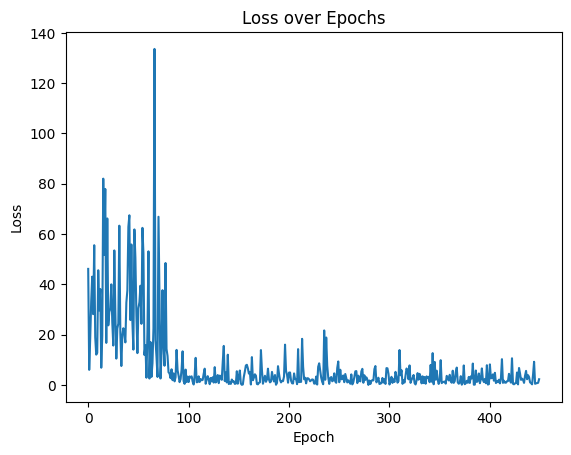

In [74]:
plt.plot(loss_list[50:])

plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

# Testing

In [75]:
import matplotlib.pyplot as plt

def plot_actual_vs_pred(pred, actual, index):
    actual_np = actual[index]
    pred_np = pred[index]


    plt.plot(actual_np, label='actual')
    plt.plot(pred_np, 'r+', label='predicted')

    plt.title("Layer 11")
    plt.xlabel("Layer")
    plt.ylabel("Temperature (K)")

    plt.legend()
    plt.show()

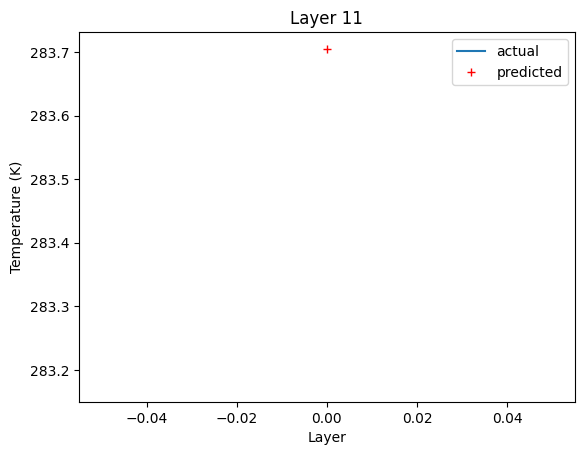

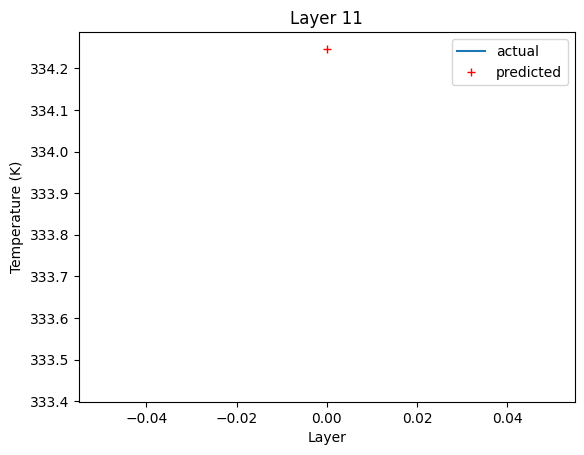

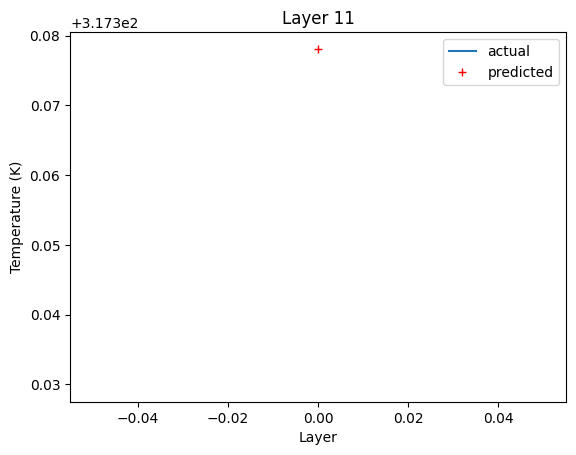

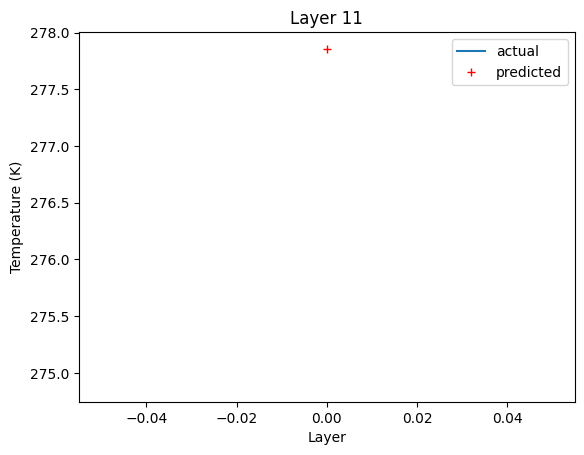

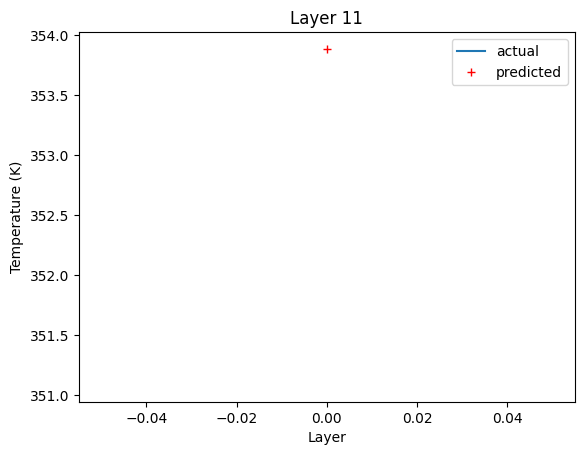

average loss: 3.3273595188603258


In [76]:
total_loss = 0
n_samples = 0
total_batches = len(test_loader)
current_batch = 0

with torch.no_grad():
    for temp_batch, spec_batch in test_loader:
        temp_pred = model(spec_batch)
        loss = criterion(temp_pred, temp_batch)
        total_loss += loss.item() * len(temp_batch)
        n_samples += len(temp_batch)
        current_batch += 1

        if current_batch % int(total_batches/5) == 0:
            plot_actual_vs_pred(temp_pred.numpy(), temp_batch.numpy(), 0) 

average_loss = total_loss/n_samples
print(f"average loss: {average_loss}")